<a href="https://colab.research.google.com/github/jaydent22/661-final-project/blob/main/bart/661_Bart_SST2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bart SST-2

This notebook will fine-tune a pretrained Bart model on the Stanford Sentiment Treebank dataset. The performance of the model will serve as one of the baselines with which to compare the performances of the autoregressive models on text classification.

## Setup

In [1]:
!pip install transformers datasets pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc
from transformers import BartTokenizerFast, BartForConditionalGeneration, BartForSequenceClassification, AdamW
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from time import time

In [3]:
cuda = torch.device('cuda')

In [4]:
model_size = "base"

### Dataset

In [5]:
dataset = load_dataset("sst2")
print(type(dataset))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.27k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

<class 'datasets.dataset_dict.DatasetDict'>


In [6]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})


In [7]:
for i, val in enumerate(dataset['train']):
    print(val)
    if i == 10:
        break

{'idx': 0, 'sentence': 'hide new secretions from the parental units ', 'label': 0}
{'idx': 1, 'sentence': 'contains no wit , only labored gags ', 'label': 0}
{'idx': 2, 'sentence': 'that loves its characters and communicates something rather beautiful about human nature ', 'label': 1}
{'idx': 3, 'sentence': 'remains utterly satisfied to remain the same throughout ', 'label': 0}
{'idx': 4, 'sentence': 'on the worst revenge-of-the-nerds clichés the filmmakers could dredge up ', 'label': 0}
{'idx': 5, 'sentence': "that 's far too tragic to merit such superficial treatment ", 'label': 0}
{'idx': 6, 'sentence': 'demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop . ', 'label': 1}
{'idx': 7, 'sentence': 'of saucy ', 'label': 1}
{'idx': 8, 'sentence': "a depressed fifteen-year-old 's suicidal poetry ", 'label': 0}
{'idx': 9, 'sentence': "are more deeply thought through than in most ` right-thinking 

## Bart Sequence Classification

Performance of sequence classification will be used merely as a comparison to text generation.

### Tokenizer

In [8]:
tokenizer = BartTokenizerFast.from_pretrained(f"facebook/bart-{model_size}")

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

In [9]:
def tokenize_data(data):
  return tokenizer(
      data["sentence"],
      padding="max_length",
      truncation=True,
      max_length=128,
      return_tensors="pt"
  )

In [10]:
tokenized_dataset = dataset.map(tokenize_data, batched=True)

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [11]:
print(tokenized_dataset)

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1821
    })
})


In [12]:
for i, val in enumerate(tokenized_dataset['train']):
    print(val)
    if i == 10:
        break

{'idx': 0, 'sentence': 'hide new secretions from the parental units ', 'label': 0, 'input_ids': [0, 37265, 92, 3556, 2485, 31, 5, 20536, 2833, 1437, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
{'idx': 1, 'sentence': 'contains no wit , only labored gags ', 'label': 0, 'input_ids': [0, 

In [13]:
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

### Dataset split

In [14]:
train_ds = tokenized_dataset["train"]
val_ds = tokenized_dataset["validation"]

In [15]:
unique, counts = np.unique(train_ds['label'], return_counts=True)
print(dict(zip(unique, counts)))

{0: 29780, 1: 37569}


In [16]:
batch_size = 32
num_workers = 4
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)

### Training

In [17]:
model = BartForSequenceClassification.from_pretrained(f"facebook/bart-{model_size}", num_labels=1)
model.to(cuda)
print(model)

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BartForSequenceClassification(
  (model): BartModel(
    (shared): BartScaledWordEmbedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_la

In [18]:
epochs = 5
optimizer = AdamW(model.parameters(), lr=1e-6)
loss_fn = torch.nn.BCEWithLogitsLoss()

In [19]:
len(train_loader)

2105

In [20]:
loss_interval = len(train_loader) // 5
model.train()
t0 = time()
for epoch in range(epochs):
  total_loss = 0.0
  for i, batch in enumerate(train_loader):
    optimizer.zero_grad()
    input_ids = batch["input_ids"].to(cuda)
    attention_mask = batch["attention_mask"].to(cuda)
    labels = batch["label"].to(cuda)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = loss_fn(outputs.logits.squeeze(), labels.float())
    total_loss += loss.item()

    loss.backward()
    optimizer.step()
    if i % loss_interval == (loss_interval - 1):
      print(f"Epoch {epoch+1}/{epochs}, Batch {i+1}/{len(train_loader)}, Loss: {total_loss / 100.0:.3f}")
      total_loss = 0.0
      print(f"Time elapsed: {time()-t0:.3f}s")
print("Training finished")

Epoch 1/5, Batch 421/2105, Loss: 2.541
Time elapsed: 78.763s
Epoch 1/5, Batch 842/2105, Loss: 1.533
Time elapsed: 155.535s
Epoch 1/5, Batch 1263/2105, Loss: 1.367
Time elapsed: 232.385s
Epoch 1/5, Batch 1684/2105, Loss: 1.328
Time elapsed: 309.175s
Epoch 1/5, Batch 2105/2105, Loss: 1.265
Time elapsed: 385.972s
Epoch 2/5, Batch 421/2105, Loss: 1.223
Time elapsed: 462.841s
Epoch 2/5, Batch 842/2105, Loss: 1.185
Time elapsed: 539.642s
Epoch 2/5, Batch 1263/2105, Loss: 1.176
Time elapsed: 616.470s
Epoch 2/5, Batch 1684/2105, Loss: 1.147
Time elapsed: 693.280s
Epoch 2/5, Batch 2105/2105, Loss: 1.144
Time elapsed: 770.033s
Epoch 3/5, Batch 421/2105, Loss: 1.072
Time elapsed: 846.974s
Epoch 3/5, Batch 842/2105, Loss: 1.088
Time elapsed: 923.766s
Epoch 3/5, Batch 1263/2105, Loss: 1.022
Time elapsed: 1000.588s
Epoch 3/5, Batch 1684/2105, Loss: 1.042
Time elapsed: 1077.467s
Epoch 3/5, Batch 2105/2105, Loss: 1.036
Time elapsed: 1154.309s
Epoch 4/5, Batch 421/2105, Loss: 1.017
Time elapsed: 1231.2

### Inference

In [24]:
model.eval()
with torch.no_grad():
  all_preds = []
  all_labels = []
  for batch in val_loader:
    input_ids = batch["input_ids"].to(cuda)
    attention_mask = batch["attention_mask"].to(cuda)
    labels = batch["label"].to(cuda)
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    preds = torch.round(torch.sigmoid(outputs.logits))
    all_preds.extend(preds.squeeze().tolist())
    all_labels.extend(labels.tolist())
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91       428
           1       0.89      0.95      0.92       444

    accuracy                           0.92       872
   macro avg       0.92      0.92      0.92       872
weighted avg       0.92      0.92      0.92       872

              precision    recall  f1-score   support

           0       0.95      0.88      0.91       428
           1       0.89      0.95      0.92       444

    accuracy                           0.92       872
   macro avg       0.92      0.92      0.92       872
weighted avg       0.92      0.92      0.92       872



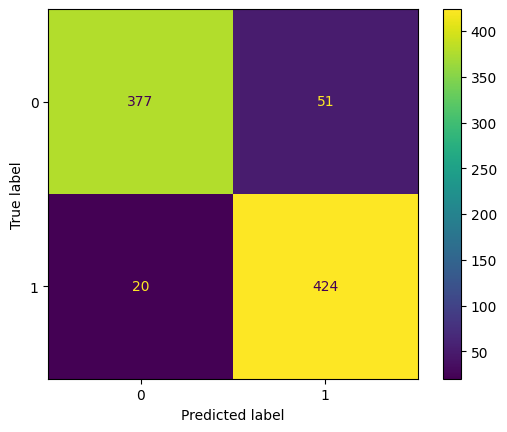

In [27]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

0.917898038225141


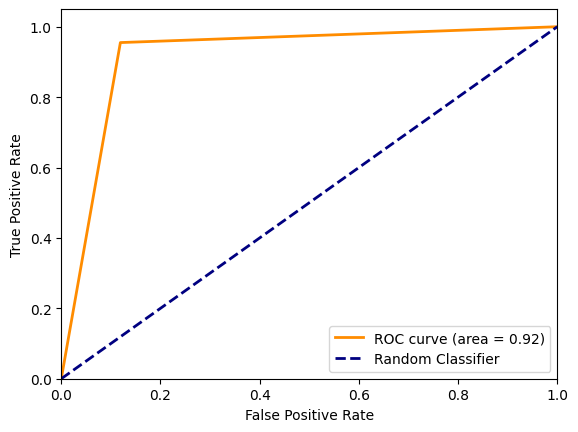

In [28]:
tpr, fpr, _ = roc_curve(all_labels, all_preds)
roc_auc = auc(tpr, fpr)
print(roc_auc)
plt.figure()
plt.plot(tpr, fpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend()

> AUC will not be used in the comparison of each model; it is included only for reference.

In [29]:
torch.save(model.state_dict(), f"bart-{model_size}-sst2-classification.pt")

In [75]:
from google.colab import files

# Specify the local path of the file
local_file_path = f'/content/bart-{model_size}-sst2-classification.pt'

# Trigger the file download
files.download(local_file_path)

# print("Download started")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Bart Conditional Generation

Performance of conditional generation will be measured as a baseline performance, as the task more closely resembles the task of sentiment generation for the autoregressive models.

In [ ]:
torch.cuda.empty_cache()

### Tokenizer

In [55]:
prefix = "Classify if the following is positive or negative: "
train_ds = dataset["train"]
val_ds = dataset["validation"]
train_ds = train_ds.map(lambda x: {"sentence": prefix + x["sentence"]})
val_ds = val_ds.map(lambda x: {"sentence": prefix + x["sentence"]})

In [56]:
label_map = {
    0: "negative",
    1: "positive"
}

def map_labels(data):
  data["sentiment"] = label_map[data["label"]]
  return data

train_ds = train_ds.map(map_labels)
val_ds = val_ds.map(map_labels)

In [57]:
for i, val in enumerate(train_ds):
    print(val)
    if i == 10:
        break

{'idx': 0, 'sentence': 'Classify if the following is positive or negative: hide new secretions from the parental units ', 'label': 0, 'sentiment': 'negative'}
{'idx': 1, 'sentence': 'Classify if the following is positive or negative: contains no wit , only labored gags ', 'label': 0, 'sentiment': 'negative'}
{'idx': 2, 'sentence': 'Classify if the following is positive or negative: that loves its characters and communicates something rather beautiful about human nature ', 'label': 1, 'sentiment': 'positive'}
{'idx': 3, 'sentence': 'Classify if the following is positive or negative: remains utterly satisfied to remain the same throughout ', 'label': 0, 'sentiment': 'negative'}
{'idx': 4, 'sentence': 'Classify if the following is positive or negative: on the worst revenge-of-the-nerds clichés the filmmakers could dredge up ', 'label': 0, 'sentiment': 'negative'}
{'idx': 5, 'sentence': "Classify if the following is positive or negative: that 's far too tragic to merit such superficial tre

In [58]:
def tokenize_data(data):
  inputs = tokenizer(
      data["sentence"],
      padding="max_length",
      truncation=True,
      max_length=100,
      return_tensors="pt"
  )
  labels = tokenizer(
      data["sentiment"],
      padding="max_length",
      truncation=True,
      max_length=3,
      return_tensors="pt"
  )
  inputs["label"] = labels["input_ids"]
  return inputs

In [59]:
train_tokenized = train_ds.map(tokenize_data, batched=True)
val_tokenized = val_ds.map(tokenize_data, batched=True)

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

In [60]:
for i, val in enumerate(train_tokenized):
    print(val)
    if i == 10:
        break

{'idx': 0, 'sentence': 'Classify if the following is positive or negative: hide new secretions from the parental units ', 'label': [0, 33407, 2], 'sentiment': 'negative', 'input_ids': [0, 21527, 4591, 114, 5, 511, 16, 1313, 50, 2430, 35, 7433, 92, 3556, 2485, 31, 5, 20536, 2833, 1437, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
{'idx': 1, 'sentence': 'Classify if the following is positive or negative: contains no wit , only labored gags ', 'label': [0, 33407, 2], 'sentiment': 'n

In [61]:
train_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [62]:
unique, counts = np.unique(train_tokenized['label'], return_counts=True)
print(dict(zip(unique, counts)))

{0: 67349, 2: 67349, 22173: 37569, 33407: 29780}


In [63]:
batch_size = 32
num_workers = 4
train_loader = DataLoader(train_tokenized, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)
val_loader = DataLoader(val_tokenized, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)

## Training

In [64]:
model = BartForConditionalGeneration.from_pretrained(f"facebook/bart-{model_size}")
model.to(cuda)
print(model)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): BartScaledWordEmbedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_lay

In [65]:
epochs = 3
optimizer = AdamW(model.parameters(), lr=1e-5)

In [66]:
loss_interval = len(train_loader) // 5
model.train()
t0 = time()
print("Training started")
for epoch in range(epochs):
  total_loss = 0.0
  for i, batch in enumerate(train_loader):
    optimizer.zero_grad()
    input_ids = batch["input_ids"].to(cuda)
    attention_mask = batch["attention_mask"].to(cuda)
    labels = batch["label"].to(cuda)
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    total_loss += loss.item()

    loss.backward()
    optimizer.step()
    if i % loss_interval == (loss_interval-1):
      print(f"Epoch {epoch+1}/{epochs}, Batch {i+1}/{len(train_loader)}, Loss: {total_loss / 100.0:.3f}")
      total_loss = 0.0
      print(f"Time elapsed: {time()-t0:.3f}s")
print("Training finished")

Training started
Epoch 1/3, Batch 421/2105, Loss: 1.020
Time elapsed: 37.974s
Epoch 1/3, Batch 842/2105, Loss: 0.421
Time elapsed: 75.673s
Epoch 1/3, Batch 1263/2105, Loss: 0.374
Time elapsed: 113.349s
Epoch 1/3, Batch 1684/2105, Loss: 0.318
Time elapsed: 151.003s
Epoch 1/3, Batch 2105/2105, Loss: 0.314
Time elapsed: 188.685s
Epoch 2/3, Batch 421/2105, Loss: 0.276
Time elapsed: 226.500s
Epoch 2/3, Batch 842/2105, Loss: 0.266
Time elapsed: 264.139s
Epoch 2/3, Batch 1263/2105, Loss: 0.254
Time elapsed: 301.743s
Epoch 2/3, Batch 1684/2105, Loss: 0.254
Time elapsed: 339.390s
Epoch 2/3, Batch 2105/2105, Loss: 0.245
Time elapsed: 377.035s
Epoch 3/3, Batch 421/2105, Loss: 0.212
Time elapsed: 414.899s
Epoch 3/3, Batch 842/2105, Loss: 0.208
Time elapsed: 452.505s
Epoch 3/3, Batch 1263/2105, Loss: 0.199
Time elapsed: 490.148s
Epoch 3/3, Batch 1684/2105, Loss: 0.200
Time elapsed: 527.837s
Epoch 3/3, Batch 2105/2105, Loss: 0.201
Time elapsed: 565.425s
Training finished


## Inference

In [67]:
model.eval()
with torch.no_grad():
  all_texts = []
  all_preds = []
  all_labels = []
  for batch in val_loader:
    outputs = model.generate(input_ids=batch["input_ids"].to(cuda), attention_mask=batch["attention_mask"].to(cuda), max_length=8)
    all_texts.extend(tokenizer.batch_decode(batch["input_ids"], skip_special_tokens=True))
    all_preds.extend(tokenizer.batch_decode(outputs, skip_special_tokens=True))
    all_labels.extend(tokenizer.batch_decode(batch["label"], skip_special_tokens=True))

In [68]:
for i in range(10):
  print("Sentence: " + all_texts[i])
  print("Predicted sentiment: " + all_preds[i])
  print("Actual sentiment: " + all_labels[i])

Sentence: Classify if the following is positive or negative: it 's a charming and often affecting journey . 
Predicted sentiment: positive
Actual sentiment: positive
Sentence: Classify if the following is positive or negative: unflinchingly bleak and desperate 
Predicted sentiment: negative
Actual sentiment: negative
Sentence: Classify if the following is positive or negative: allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker . 
Predicted sentiment: positive
Actual sentiment: positive
Sentence: Classify if the following is positive or negative: the acting , costumes , music , cinematography and sound are all astounding given the production 's austere locales . 
Predicted sentiment: positive
Actual sentiment: positive
Sentence: Classify if the following is positive or negative: it 's slow -- very , very slow . 
Predicted sentiment: negative
Actual sentiment: negative
Sentence: Classify if the following is positive or negative: althou

In [69]:
preds = np.array([1 if x == "positive" else 0 for x in all_preds])
labels = np.array([1 if x == "positive" else 0 for x in all_labels])

print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       428
           1       0.93      0.94      0.93       444

    accuracy                           0.93       872
   macro avg       0.93      0.93      0.93       872
weighted avg       0.93      0.93      0.93       872



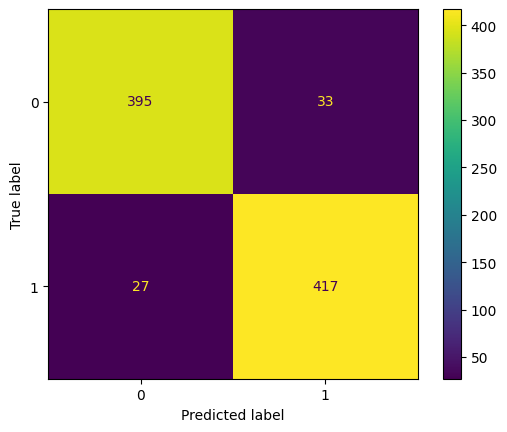

In [70]:
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

0.9310431927254357


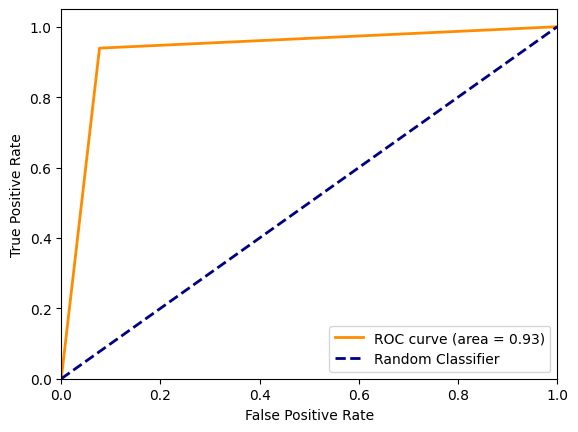

In [71]:
tpr, fpr, _ = roc_curve(labels, preds)
roc_auc = auc(tpr, fpr)
print(roc_auc)
plt.figure()
plt.plot(tpr, fpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend()

> AUC will not be used in the comparison of each model; it is included only for reference.

The text generation model outperforms the sentiment classification model. As Bart was trained for text recovery from corruption, it is better suited to treat sentiment analysis as a text generation task rather than a classification task.

In [72]:
torch.save(model.state_dict(), f"bart-{model_size}-sst2-generation.pt")

In [74]:
local_file_path = f'/content/bart-{model_size}-sst2-generation.pt'

files.download(local_file_path)

print("Download started")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download started
